In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [14]:
# read the data
path = "C:/Users/WenBi/Desktop/stock-prediction/dataset/"
filename = "FB.csv"
file = os.path.join(path,filename)
dataset = pd.read_csv(file, index_col="Date")
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-23,182.500000,186.910004,182.179993,186.899994,186.899994,16628100
2018-05-24,185.880005,186.800003,185.029999,185.929993,185.929993,12354700
2018-05-25,186.020004,186.330002,184.449997,184.919998,184.919998,10965100
2018-05-29,184.339996,186.809998,183.710007,185.740005,185.740005,16398900
2018-05-30,186.539993,188.000000,185.250000,187.669998,187.669998,13736900


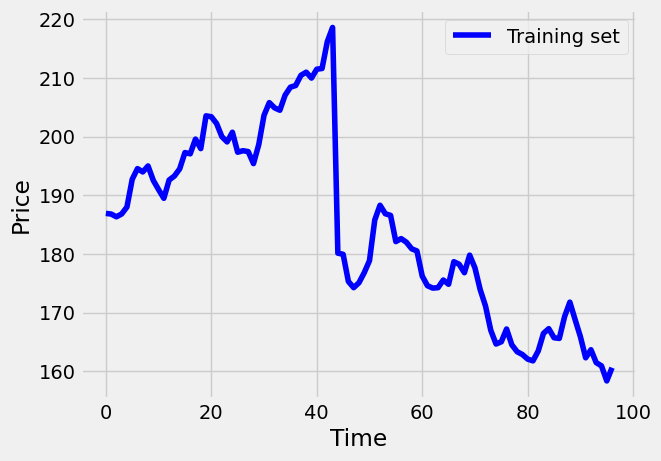

In [15]:
training_set = dataset[:'2018-10-09'].iloc[:,1:2].values
test_set = dataset['2018-10-09':].iloc[:,1:2].values

plt.plot(training_set, color='blue', label='Training set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [16]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

lookback = 20
X_train = []   # feature
y_train = []   # lable
for i in range(lookback, len(training_set)):
    # 序列长度为19
    X_train.append(training_set_scaled[i-20:i,0])
    # 标签长度为1
    y_train.append(training_set_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [17]:
from keras import backend as K

smooth = 1e-5

def dice_coef_loss(y_true, y_pred):
    y_truef = K.flatten(y_true)  # 将 y_true 拉为一维
    y_predf = K.flatten(y_pred)
    intersection = K.sum(y_truef * y_predf)
    dice_coef = (2 * intersection + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth)
    return 1-dice_coef

In [18]:
# 定义模型LSTM
regressor = Sequential()
# 往模型里面加模块， first LSTM layer
regressor.add(LSTM(units=32,return_sequences=True, input_shape=(X_train.shape[1],1)))
# regressor.add(Dropout(0.2))
# second LSTM layer
# regressor.add(LSTM(units=80, return_sequences=True))
# regressor.add(Dropout(0.2))
# third LSTM layer
regressor.add(LSTM(units=32))
# regressor.add(Dropout(0.2))
# output layer
regressor.add(Dense(units=1))
# compile the LSTM， loss: 'mse', 'mae'
# regressor.compile(optimizer='rmsprop', loss='mae')
regressor.compile(optimizer='rmsprop', loss=dice_coef_loss)
# fit to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
2/2 [==============================] - 3s 12ms/step - loss: 1.2165
Epoch 2/100
2/2 [==============================] - 0s 12ms/step - loss: 0.7919
Epoch 3/100
2/2 [==============================] - 0s 11ms/step - loss: 0.6480
Epoch 4/100
2/2 [==============================] - 0s 12ms/step - loss: 0.5410
Epoch 5/100
2/2 [==============================] - 0s 12ms/step - loss: 0.4562
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 0.3802
Epoch 7/100
2/2 [==============================] - 0s 12ms/step - loss: 0.3197
Epoch 8/100
2/2 [==============================] - 0s 11ms/step - loss: 0.2605
Epoch 9/100
2/2 [==============================] - 0s 11ms/step - loss: 0.2342
Epoch 10/100
2/2 [==============================] - 0s 14ms/step - loss: 0.2108
Epoch 11/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1878
Epoch 12/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1704
Epoch 13/100
2/2 [==============================]

In [19]:
dataset_total = pd.concat((dataset['High'][:'2018-10-09'], dataset['High']['2018-10-09':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 20:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [20]:
X_test = []
for i in range(lookback, len(inputs)):
    X_test.append(inputs[i - lookback:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
LSTM_predicted_stock_price = regressor.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

5/5 [==============================] - 1s 5ms/step


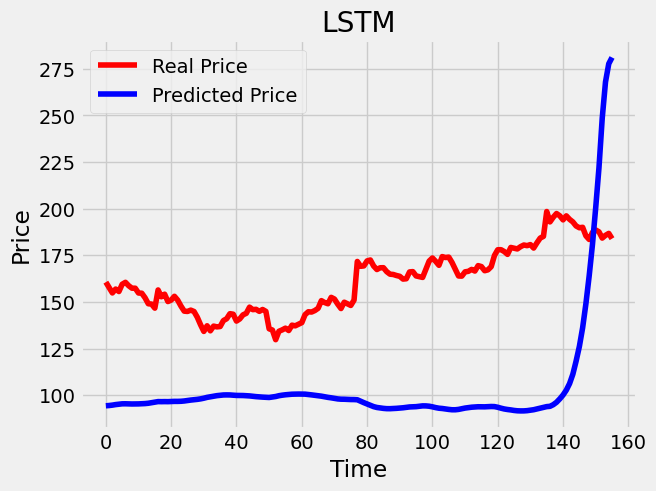

In [21]:
plt.plot(test_set, color='red', label='Real Price')
plt.plot(LSTM_predicted_stock_price, color='blue', label='Predicted Price')
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
LSTM_rmse = mean_squared_error(test_set, LSTM_predicted_stock_price)
print ("root mean squared error is {}.".format(LSTM_rmse))

root mean squared error is 5232.960968876642.
